# Nuclear Power Generation Forecasting & Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import IsolationForest
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split

In [2]:
from google.colab import files
uploaded = files.upload()

Saving Dataset_for_nuclear_power.csv to Dataset_for_nuclear_power.csv


In [15]:
# Load Dataset
data = "Dataset_for_nuclear_power.csv"
df = pd.read_csv(data)

In [8]:
# Data Preprocessing
df.rename(columns={"Electricity Generation (Million Units)": "Electricity_Generated"}, inplace=True)
df["Year"] = df["Year"].astype(str).str[:4].astype(int)
df["Electricity_Generated"] = pd.to_numeric(df["Electricity_Generated"], errors="coerce")
df_cleaned = df.groupby("Year")["Electricity_Generated"].sum().reset_index()

In [9]:
# Set Year as index
df_cleaned["Year"] = pd.to_datetime(df_cleaned["Year"], format="%Y")
df_cleaned.set_index("Year", inplace=True)

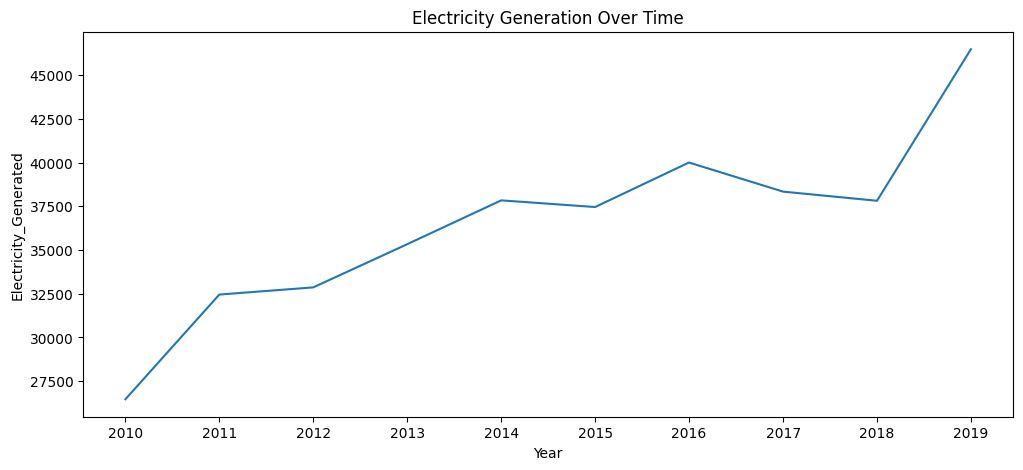

In [10]:
# Visualization of Trends
plt.figure(figsize=(12,5))
sns.lineplot(data=df_cleaned, x=df_cleaned.index, y="Electricity_Generated")
plt.title("Electricity Generation Over Time")
plt.show()

In [11]:
# ARIMA Forecasting
model_arima = ARIMA(df_cleaned["Electricity_Generated"], order=(5,1,0))
model_fit = model_arima.fit()
predictions_arima = model_fit.forecast(steps=5)
print("ARIMA Predictions:", predictions_arima)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


ARIMA Predictions: 2020-01-01    48811.803701
2021-01-01    48566.520145
2022-01-01    50473.782184
2023-01-01    47671.062574
2024-01-01    52364.912288
Freq: YS-JAN, Name: predicted_mean, dtype: float64


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 7.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpikr_1mfi/3dbur8b2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpikr_1mfi/d8qa2rav.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77977', 'data', 'file=/tmp/tmpikr_1mfi/3dbur8b2.json', 'init=/tmp/tmpikr_1mfi/d8qa2rav.json', 'output', 'file=/tmp/tmpikr_1mfi/prophet_model98gl_x69/prophet_model-20250228175706.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
17:57:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:57:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:c

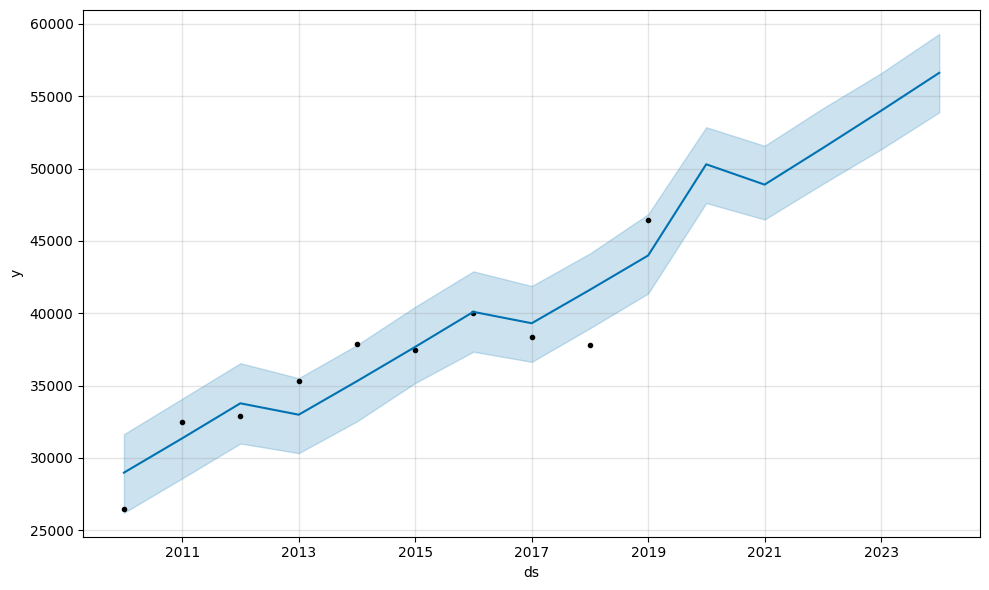

In [12]:
# Prophet Forecasting
df_prophet = df_cleaned.reset_index().rename(columns={"Year": "ds", "Electricity_Generated": "y"})
model_prophet = Prophet()
model_prophet.fit(df_prophet)
future = model_prophet.make_future_dataframe(periods=5, freq='Y')
forecast = model_prophet.predict(future)
model_prophet.plot(forecast)
plt.show()

In [13]:
# Deep Learning Forecasting (LSTM)
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df_cleaned[["Electricity_Generated"]])
X, y = [], []
for i in range(5, len(data_scaled)):
    X.append(data_scaled[i-5:i, 0])
    y.append(data_scaled[i, 0])
X, y = np.array(X), np.array(y)
X = X.reshape((X.shape[0], X.shape[1], 1))

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model_lstm = Sequential([
    LSTM(50, activation='relu', return_sequences=True, input_shape=(5, 1)),
    LSTM(50, activation='relu'),
    Dense(1)
])
model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.fit(X_train, y_train, epochs=50, batch_size=8, verbose=0)
predictions_lstm = model_lstm.predict(X_test)
predictions_lstm = scaler.inverse_transform(predictions_lstm)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 863ms/step


In [16]:
# Anomaly Detection (Isolation Forest)
iso_forest = IsolationForest(contamination=0.05)
df_cleaned["Anomaly_Score"] = iso_forest.fit_predict(df_cleaned[["Electricity_Generated"]])
anomalies = df_cleaned[df_cleaned["Anomaly_Score"] == -1]
print("Detected Anomalies:", anomalies)

Detected Anomalies:             Electricity_Generated  Anomaly_Score
Year                                            
2010-01-01                26472.0             -1


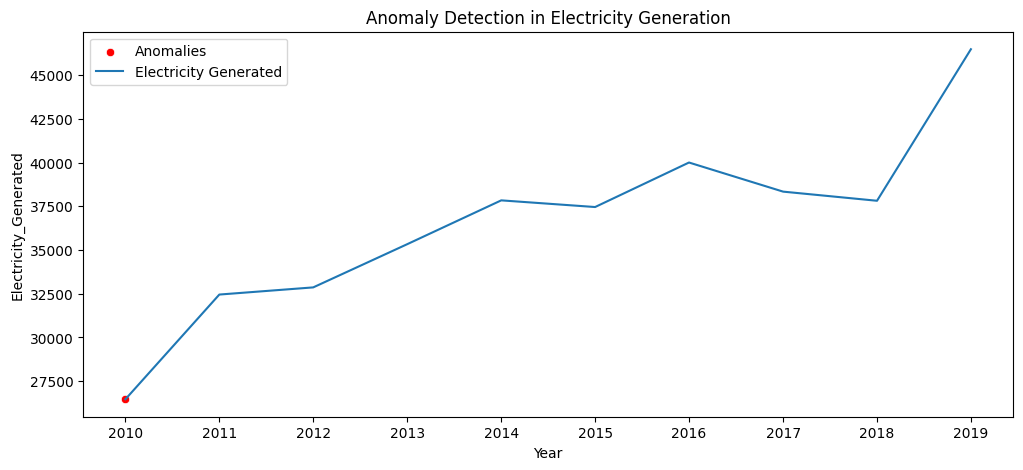

In [17]:
# Visualization of Anomalies
plt.figure(figsize=(12,5))
sns.scatterplot(data=anomalies, x=anomalies.index, y='Electricity_Generated', color='red', label='Anomalies')
sns.lineplot(data=df_cleaned, x=df_cleaned.index, y='Electricity_Generated', label='Electricity Generated')
plt.title("Anomaly Detection in Electricity Generation")
plt.show()

In [18]:
# Decision Recommendations
def decision_recommendations(predictions):
    if predictions[-1] < predictions[-2]:
        return "Warning: Decreasing trend detected. Consider optimizing operations."
    elif predictions[-1] > predictions[-2] * 1.1:
        return "Opportunity: Significant increase detected. Plan for higher capacity utilization."
    else:
        return "Stable trends. No immediate action required."

print(decision_recommendations(predictions_arima))

Stable trends. No immediate action required.


<ipython-input-18-73cbc14d8c51>:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if predictions[-1] < predictions[-2]:
<ipython-input-18-73cbc14d8c51>:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif predictions[-1] > predictions[-2] * 1.1:


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed t

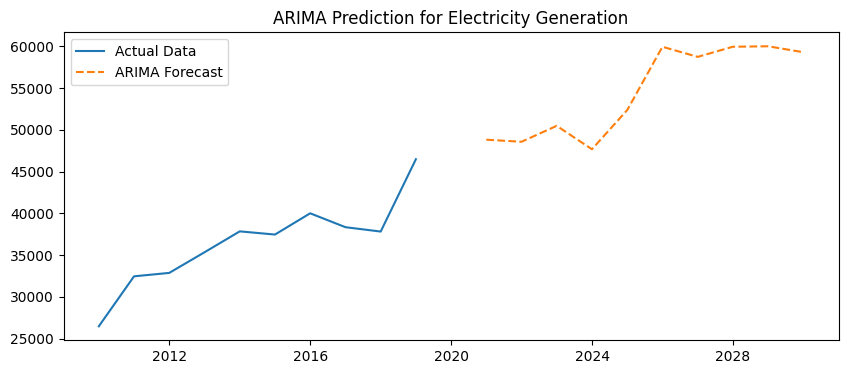

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 7.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpikr_1mfi/hwmixqxy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpikr_1mfi/pchqeqn_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14187', 'data', 'file=/tmp/tmpikr_1mfi/hwmixqxy.json', 'init=/tmp/tmpikr_1mfi/pchqeqn_.json', 'output', 'file=/tmp/tmpikr_1mfi/prophet_modelc3rid7s5/prophet_model-20250228175949.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
17:59:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:59:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:c

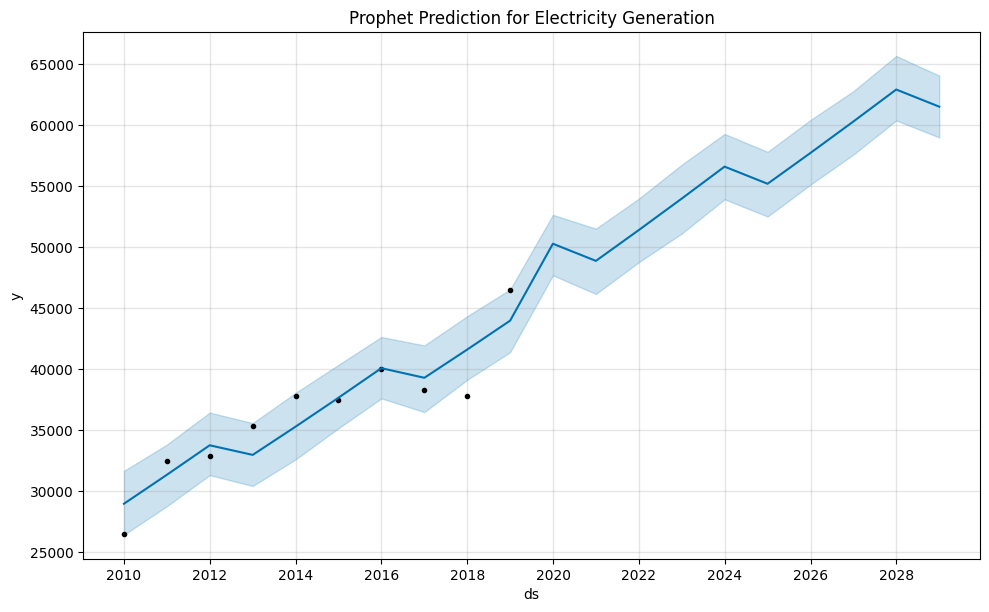

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


<ipython-input-19-571ae17f980e>:85: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  plt.plot(pd.date_range(df_cleaned.index[-1], periods=future_steps+1, freq='Y')[1:], predictions_lstm, label="LSTM Forecast", linestyle="dashed")


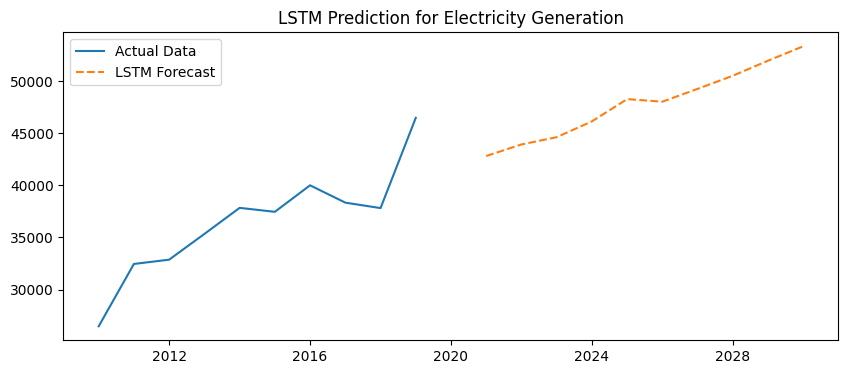

🔹 ARIMA Forecast: 2020-01-01    48811.803701
2021-01-01    48566.520145
2022-01-01    50473.782184
2023-01-01    47671.062574
2024-01-01    52364.912288
2025-01-01    59941.360505
2026-01-01    58731.342933
2027-01-01    59944.436275
2028-01-01    59999.923078
2029-01-01    59285.581186
Freq: YS-JAN, Name: predicted_mean, dtype: float64
🔹 Prophet Forecast (Last 10 years):
            ds          yhat
10 2019-12-31  50298.524177
11 2020-12-31  48892.908597
12 2021-12-31  51420.388385
13 2022-12-31  53997.400206
14 2023-12-31  56622.455596
15 2024-12-31  55216.840016
16 2025-12-31  57744.319805
17 2026-12-31  60321.331625
18 2027-12-31  62946.387015
19 2028-12-31  61540.771435
🔹 LSTM Forecast: [42811.703 43920.16  44617.66  46129.504 48272.816 48026.027 49254.566
 50510.547 51960.715 53343.305]


In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Load the dataset

# Data Preprocessing
df.rename(columns={"Electricity Generation (Million Units)": "Electricity_Generated"}, inplace=True)
df["Year"] = df["Year"].astype(str).str[:4].astype(int)
df["Electricity_Generated"] = pd.to_numeric(df["Electricity_Generated"], errors="coerce")
df_cleaned = df.groupby("Year")["Electricity_Generated"].sum().reset_index()

# Convert Year to datetime and set index
df_cleaned["Year"] = pd.to_datetime(df_cleaned["Year"], format="%Y")
df_cleaned.set_index("Year", inplace=True)

# --------- 🔹 ARIMA Forecasting 🔹 ---------
model_arima = ARIMA(df_cleaned["Electricity_Generated"], order=(5,1,0))
model_fit = model_arima.fit()
future_steps = 10  # Predict next 10 years
predictions_arima = model_fit.forecast(steps=future_steps)

# Plot ARIMA predictions
plt.figure(figsize=(10, 4))
plt.plot(df_cleaned.index, df_cleaned["Electricity_Generated"], label="Actual Data")
plt.plot(pd.date_range(df_cleaned.index[-1], periods=future_steps+1, freq='Y')[1:], predictions_arima, label="ARIMA Forecast", linestyle="dashed")
plt.legend()
plt.title("ARIMA Prediction for Electricity Generation")
plt.show()

# --------- 🔹 Prophet Forecasting 🔹 ---------
df_prophet = df_cleaned.reset_index().rename(columns={"Year": "ds", "Electricity_Generated": "y"})
model_prophet = Prophet()
model_prophet.fit(df_prophet)
future = model_prophet.make_future_dataframe(periods=future_steps, freq="Y")
forecast = model_prophet.predict(future)

# Plot Prophet predictions
model_prophet.plot(forecast)
plt.title("Prophet Prediction for Electricity Generation")
plt.show()

# --------- 🔹 LSTM Forecasting 🔹 ---------
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df_cleaned[["Electricity_Generated"]])

# Prepare LSTM training data
X, y = [], []
sequence_length = 5
for i in range(sequence_length, len(data_scaled)):
    X.append(data_scaled[i-sequence_length:i, 0])
    y.append(data_scaled[i, 0])
X, y = np.array(X), np.array(y)
X = X.reshape((X.shape[0], X.shape[1], 1))

# Train LSTM model
model_lstm = Sequential([
    LSTM(50, activation='relu', return_sequences=True, input_shape=(sequence_length, 1)),
    LSTM(50, activation='relu'),
    Dense(1)
])
model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.fit(X, y, epochs=50, batch_size=8, verbose=0)

# Generate LSTM predictions
future_input = data_scaled[-sequence_length:].reshape(1, sequence_length, 1)
predictions_lstm = []
for _ in range(future_steps):
    pred = model_lstm.predict(future_input)[0, 0]
    predictions_lstm.append(pred)
    future_input = np.append(future_input[:, 1:, :], [[[pred]]], axis=1)

# Convert predictions back to original scale
predictions_lstm = scaler.inverse_transform(np.array(predictions_lstm).reshape(-1, 1))

# Plot LSTM predictions
plt.figure(figsize=(10, 4))
plt.plot(df_cleaned.index, df_cleaned["Electricity_Generated"], label="Actual Data")
plt.plot(pd.date_range(df_cleaned.index[-1], periods=future_steps+1, freq='Y')[1:], predictions_lstm, label="LSTM Forecast", linestyle="dashed")
plt.legend()
plt.title("LSTM Prediction for Electricity Generation")
plt.show()

# --------- 🔹 Comparing Predictions 🔹 ---------
print("🔹 ARIMA Forecast:", predictions_arima)
print("🔹 Prophet Forecast (Last 10 years):\n", forecast.tail(10)[["ds", "yhat"]])
print("🔹 LSTM Forecast:", predictions_lstm.flatten())
